In [9]:
import pandas as pd
from openai import AzureOpenAI
import numpy as np
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path='../secrets.env')
from pyspark.sql import SparkSession
from pyspark.sql.types import *

True

In [1]:
import pandas as pd
from sqlalchemy import create_engine

# Make a connection to the database of Netivity / Optimizers using SQLAlchemy
connection_string = 'mssql+pyodbc:///?odbc_connect=' \
                    'Driver%3D%7BODBC+Driver+17+for+SQL+Server%7D%3B' \
                    'Server%3Dsql-maxaro-prod.database.windows.net%3B' \
                    'Database%3Dsqldb-maxaro-prod%3B' \
                    'UID%3Dbiadmin@maxaro.nl%3B' \
                    'Authentication%3DActiveDirectoryInteractive'

engine = create_engine(connection_string)

sql = """SELECT
A.ProductId, A.ArticleNumber, A.Name,

CategoryProduct.Parent_Category AS 'Parent Category', CategoryProduct.Category AS Category,

Benefits.Benefits_1 AS Productvoordelen_1, Benefits.Benefits_2 AS Productvoordelen_2, Benefits.Benefits_3 AS Productvoordelen_3, Benefits.Benefits_4 AS Productvoordelen_4, Benefits.Benefits_5 AS Productvoordelen_5,

USP_codes.USP_1, USP_codes.USP_2, USP_codes.USP_3,

B3.Value AS Productomschrijving, 
B5.Value AS WarningText,
B6.Value AS WarningUrgentText,
B7.Value AS ExtraInformation,
B8.Value AS 'Standaard meegeleverd',
V.Name AS 'Product Variant'

FROM Products AS A

LEFT JOIN (SELECT Cate_Group.ProductID, Cate.Parent_Category, Cate.Category
FROM [dbo].[CategoryProducts] AS Cate_Group
LEFT JOIN (SELECT B.Name As Parent_Category, Categories.Name AS Category, Categories.CategoryId
FROM Categories AS Categories
LEFT JOIN Categories AS B
ON Categories.ParentCategoryId = B.CategoryId) AS Cate
ON Cate_Group.categoryID = Cate.CategoryId
WHERE Cate_Group.IsMainCategoryForProduct = 1) AS CategoryProduct
ON A.ProductId = CategoryProduct.ProductId

LEFT JOIN(SELECT USP.ProductId, Y1.Value AS Benefits_1, Y2.Value AS Benefits_2, Y3.Value AS Benefits_3, Y4.Value AS Benefits_4, Y5.Value AS Benefits_5
FROM
(SELECT productID,
    MAX(CASE WHEN Sequence = 0 THEN textlocalizedtextid END) AS Sequence0,
    MAX(CASE WHEN Sequence = 1 THEN textlocalizedtextid END) AS Sequence1,
    MAX(CASE WHEN Sequence = 2 THEN textlocalizedtextid END) AS Sequence2,
	MAX(CASE WHEN Sequence = 3 THEN textlocalizedtextid END) AS Sequence3,
	MAX(CASE WHEN Sequence = 4 THEN textlocalizedtextid END) AS Sequence4
FROM [dbo].[ProductBenefits]
GROUP BY productID) AS USP
LEFT JOIN LocalizedTextValues AS Y1
ON USP.Sequence0 = Y1.LocalizedTextId
LEFT JOIN LocalizedTextValues AS Y2
ON USP.Sequence1 = Y2.LocalizedTextId
LEFT JOIN LocalizedTextValues AS Y3
ON USP.Sequence2 = Y3.LocalizedTextId
LEFT JOIN LocalizedTextValues AS Y4
ON USP.Sequence3 = Y4.LocalizedTextId
LEFT JOIN LocalizedTextValues AS Y5
ON USP.Sequence4 = Y5.LocalizedTextId) AS Benefits
ON A.ProductId = Benefits.ProductID

LEFT JOIN (SELECT USP.ProductId, X1.Value AS USP_1, X2.Value AS USP_2, X3.Value AS USP_3
FROM(
SELECT productID,
    MAX(CASE WHEN Sequence = 0 THEN TextLocalizedTextId END) AS Sequence0,
    MAX(CASE WHEN Sequence = 1 THEN TextLocalizedTextId END) AS Sequence1,
    MAX(CASE WHEN Sequence = 2 THEN TextLocalizedTextId END) AS Sequence2
FROM ProductUsps
GROUP BY productID) AS USP
LEFT JOIN LocalizedTextValues AS X1
ON USP.Sequence0 = X1.LocalizedTextId
LEFT JOIN LocalizedTextValues AS X2
ON USP.Sequence1 = X2.LocalizedTextId
LEFT JOIN LocalizedTextValues AS X3
ON USP.Sequence2 = X3.LocalizedTextId) AS USP_codes
ON A.ProductId = USP_codes.ProductId

LEFT JOIN ProductVariants AS V
ON A.ProductVariantId = V.ProductVariantId
LEFT JOIN LocalizedTextValues AS B3
ON A.DescriptionLocalizedTextId = B3.LocalizedTextId
LEFT JOIN LocalizedTextValues AS B5
ON A.WarningTextLocalizedTextId = B5.LocalizedTextId
LEFT JOIN LocalizedTextValues AS B6
ON A.WarningUrgentTextLocalizedTextId = B6.LocalizedTextId
LEFT JOIN LocalizedTextValues AS B7
ON A.ExtraInformationLocalizedTextId = B7.LocalizedTextId
LEFT JOIN LocalizedTextValues AS B8
ON A.DefaultIncludedLocalizedTextId = B8.LocalizedTextId
"""

json_data = pd.read_sql(sql, engine)

# Close the database connection
engine.dispose()


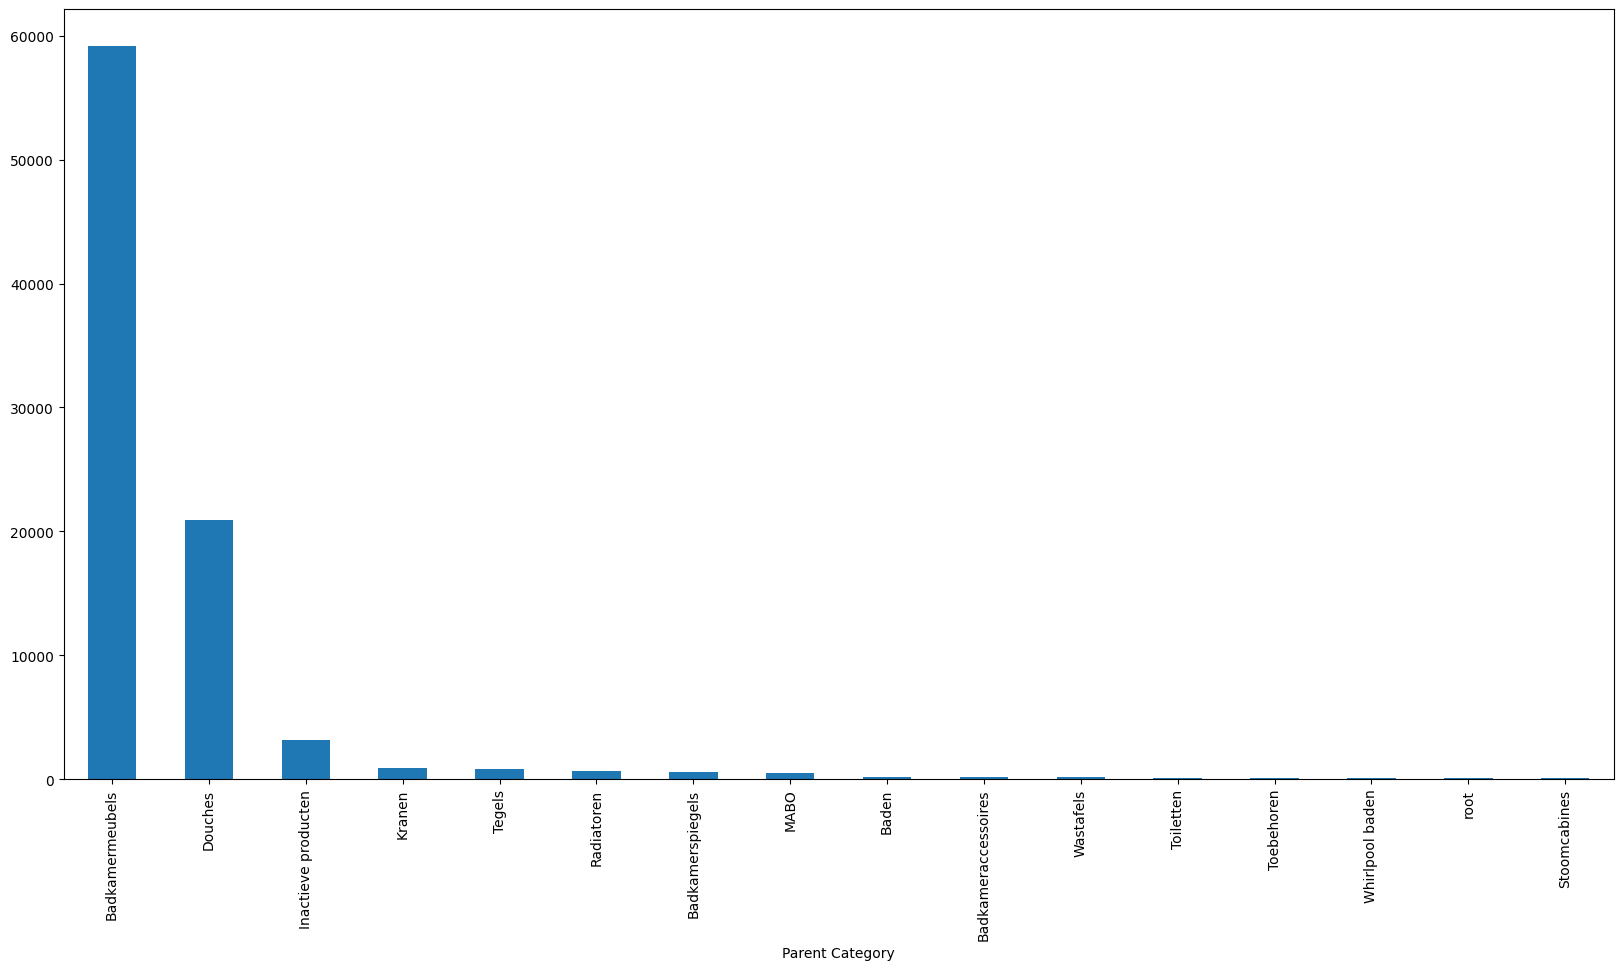

In [2]:
import matplotlib.pyplot as plt
# make barplot of the number of products per category
plt.figure(figsize=(20,10))
json_data['Parent Category'].value_counts().plot(kind='bar')
plt.show()

In [17]:
prodDes = json_data[(json_data['Productomschrijving'].isna()) & (json_data['Parent Category'] != 'Inactieve producten') & (json_data['Parent Category'] != 'Toebehoren')]
prodDesNotNA = json_data[(json_data['Productomschrijving'].notna()) & (json_data['Parent Category'] != 'Inactieve producten') & (json_data['Parent Category'] != 'Toebehoren')]

In [4]:
mask = prodDes[['Productvoordelen_1', 'Productvoordelen_2', 'Productvoordelen_3', 'Productvoordelen_4', 'Productvoordelen_5']].dropna(thresh=2).index

# Use the mask to filter the entire prodDes DataFrame
prodDes_filtered = prodDes.loc[mask]

In [5]:
engine = create_engine(connection_string)

# Construct your SQL query. This is just an example.
query = f"""SELECT A.ProductId, P.ArticleNumber, P.Name, A.Property, B.Value
        FROM ProductDynamicPropertyValues AS A
        LEFT JOIN LocalizedTextValues AS B
        ON A.ValueLocalizedTextId = B.LocalizedTextId
        LEFT JOIN Products AS P
        ON A.ProductId = P.ProductId"""

try:
    specs = pd.read_sql(query, engine)

finally:
    engine.dispose()

In [6]:
def concatenate_properties(series):
    return ', '.join(series.dropna().unique())

specs['Specifications'] = specs['Property'].astype(str) + ': ' + specs['Value'].astype(str)
grouped_specs = specs.groupby(['ProductId', 'ArticleNumber', 'Name']).agg({
    'Specifications': concatenate_properties
}).reset_index()

# Merge with prodDes_filtered
result_df = pd.merge(prodDes_filtered, grouped_specs, on=['ProductId', 'ArticleNumber', 'Name'], how='inner')


In [42]:
result_columns = ['ProductId', 'ArticleNumber', 'Name', 'Productvoordelen_1', 'Productvoordelen_2', 'Productvoordelen_3', 'Productvoordelen_4', 'Productvoordelen_5', 'USP_1', 'USP_2', 'USP_3', 'Product Variant', 'Specifications']
description_columns = ['Productomschrijving', 'Product Variant']

In [27]:
def generate_template(description):
    return

In [44]:
matched_df = pd.merge(result_df[result_columns], prodDesNotNA[description_columns], on='Product Variant', how='inner', suffixes=('_result', '_prodDes'))

generate_template(matched_df['Productomschrijving'])

MemoryError: Unable to allocate 6.26 GiB for an array with shape (11, 76350650) and data type object

In [ ]:
matched_df

,ProductId,ArticleNumber,Name,Parent Category,Category,Productvoordelen_1,Productvoordelen_2,Productvoordelen_3,Productvoordelen_4,Productvoordelen_5,USP_1,USP_2,USP_3,Productomschrijving,WarningText,WarningUrgentText,ExtraInformation,Standaard meegeleverd,Product Variant,Specifications
0,77737,T06-1000-30500,Modulo Wastafelblad | 100 cm Mat wit,Badkamermeubels,Wastafelbladen,"Te plaatsen op een meubel, of wand middels wan...",Voorzien van installatieclips,Massief uiterlijk vanwege de 36 mm dikte,Afvoergaten en kraangaten naar eigen wens te b...,Verkrijgbaar in diverse afmetingen en kleuren,Mat wit,"100x3,6x46 cm",None,None,None,None,None,None,T06,"Wastafelbladen_NumberOfItems: 1, Product_Wasta..."
1,77741,T06-1200-30500,Modulo Wastafelblad | 120 cm Mat wit,Badkamermeubels,Wastafelbladen,"Te plaatsen op een meubel, of wand middels wan...",Voorzien van installatieclips,Massief uiterlijk vanwege de 36 mm dikte,Afvoergaten en kraangaten naar eigen wens te b...,Verkrijgbaar in diverse afmetingen en kleuren,Mat wit,"120x3,6x46 cm",None,None,None,None,None,None,T06,"Wastafelbladen_NumberOfItems: 1, Product_Wasta..."
2,77745,T06-0800-30500,Modulo Wastafelblad | 80 cm Mat wit,Badkamermeubels,Wastafelbladen,"Te plaatsen op een meubel, of wand middels wan...",Voorzien van installatieclips,Massief uiterlijk vanwege de 36 mm dikte,Afvoergaten en kraangaten naar eigen wens te b...,Verkrijgbaar in diverse afmetingen en kleuren,Mat wit,"80x3,6x46 cm",None,None,None,None,None,None,T06,"Wastafelbladen_NumberOfItems: 1, Product_Wasta..."
3,77760,T06-1000-33200,Modulo Wastafelblad | 100 cm Eiken,Badkamermeubels,Wastafelbladen,"Te plaatsen op een meubel, of wand middels wan...",Voorzien van installatieclips,Massief uiterlijk vanwege de 36 mm dikte,Afvoergaten en kraangaten naar eigen wens te b...,Verkrijgbaar in diverse afmetingen en kleuren,Eiken,"100x3,6x46 cm",None,None,None,None,None,None,T06,"Wastafelbladen_NumberOfItems: 1, Product_Wasta..."
4,77761,T06-1000-30400,Modulo Wastafelblad | 100 cm Hoogglans wit,Badkamermeubels,Wastafelbladen,"Te plaatsen op een meubel, of wand middels wan...",Voorzien van installatieclips,Massief uiterlijk vanwege de 36 mm dikte,Afvoergaten en kraangaten naar eigen wens te b...,Verkrijgbaar in diverse afmetingen en kleuren,Hoogglans wit,"100x3,6x46 cm",None,None,None,None,None,None,T06,"Wastafelbladen_NumberOfItems: 1, Product_Wasta..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22817,155482,DDB21452121BR,Diamond Douchedeur | 90 cm Rvs Rookglas Draaideur,Douches,Douchedeuren,Dankzij de draaideur heeft u de volledige inst...,"Het glas is behandeld met Nano-Tech, een besch...",Het liftingsysteem tilt de deur op bij een dra...,De verstelbaarheid zorgt ervoor dat u de douch...,None,200 cm hoog,8 mm veiligheidsglas,"Verstelbaar tussen 91,7 - 92,7 cm",None,Dankzij onze eigen productontwikkeling bieden ...,De douchedeur beschikt over een verstelbaarhei...,None,* Bevestigingsmateriaal\n* Installatiehandleiding,"DDB, 273 profiel, 40, 50 cm","Product_Douchedeuren_Hoogte: 200 cm, Product_D..."
22818,155483,DDB21452120BR,Diamond Douchedeur | 90 cm Rvs Helder glas Dra...,Douches,Douchedeuren,Dankzij de draaideur heeft u de volledige inst...,"Het glas is behandeld met Nano-Tech, een besch...",Het liftingsysteem tilt de deur op bij een dra...,De verstelbaarheid zorgt ervoor dat u de douch...,None,200 cm hoog,8 mm veiligheidsglas,"Verstelbaar tussen 91,7 - 92,7 cm",None,Dankzij onze eigen productontwikkeling bieden ...,De douchedeur beschikt over een verstelbaarhei...,None,* Bevestigingsmateriaal\n* Installatiehandleiding,"DDB, 273 profiel, 40, 50 cm","Product_Douchedeuren_Hoogte: 200 cm, Product_D..."
22819,155484,DDB21452113BR,Diamond Douchedeur | 90 cm Rvs Helder met matt...,Douches,Douchedeuren,Dankzij de draaideur heeft u de volledige inst...,"Het glas is behandeld met Nano-Tech, een besch...",Het liftingsysteem tilt de deur op bij een dra...,De verstelbaarheid zorgt ervoor dat u de

In [10]:
client = AzureOpenAI(
    api_key = os.environ.get("AZURE_OPENAI_KEY"),
    api_version = os.environ.get("AZURE_API_VERSION"),
    azure_endpoint = os.environ.get("AZURE_ENDPOINT")
    )

In [31]:
df_prodDes = pd.DataFrame(columns=['Product', 'Description'])
new_row = {'Product': '', 'Description': ''}
for index, row in result_df.iterrows():
    text = row['Name'] + ' ' + row['Specifications'] + ' ' + row['Productvoordelen_1'] + ' ' + row['Productvoordelen_2'] + ' ' + row['Productvoordelen_3'] + ' ' + row['Productvoordelen_4'] + ' ' + row['Productvoordelen_5']

    response = client.chat.completions.create(
        model="gpt-35-turbo",
        messages = [
            {"role": "system", "content": "Maak een overtuigende en positieve productbeschrijving voor het volgende artikel. Benadruk de belangrijkste kenmerken, voordelen en onderscheidende eigenschappen. Gebruik duidelijke en begrijpelijke taal om de lezer te boeien. Stel je voor dat je tegen een potentiële klant spreekt die op zoek is naar de beste eigenschappen van het product. Maak de beschrijving ongeveer 150-200 woorden. Verder moet de tekst seo-geoptimaliseerd zijn, dus let op: Schrijf voor kopers, niet voor bots; Benadruk voordelen, voeg functies toe; Richt je op de juiste SEO-productzoekwoorden; Plaats zoekwoorden strategisch in je tekst; Laat de lengte afhangen van de bekendheid van de koper; Maak een duidelijke call-to-action; Maak unieke productbeschrijvingen voor elk POP. Tot slot en erg belangrijk: als het product erg lijkt op een eerder product dat u had, bijvoorbeeld alleen een andere kleur of maat, hergebruik dan dezelfde beschrijving en verander alleen de details."},
            {"role": "user", "content": f"Dit is het product waarvoor we een beschrijving nodig hebben: {text}, en dit is de eerder gegenereerde beschrijving: {new_row['Description']}"},
        ])
    new_row = {'Product': row['Name'], 'Description': response.choices[0].message.content}
    df_prodDes.loc[len(df_prodDes)] = new_row

KeyboardInterrupt: 

In [ ]:
#df_prodDes.to_excel('train_data.xlsx', index=False)